# Object Detection Using YOLO v5 (Part-3)

### Welcome to the 9th Lab of 42028: Deep Learning and CNN!

In this part of the Lab/Tutorial session you will be exploring how to use the YOLO v5 object detector


So lets get started!


We will use the https://github.com/ultralytics/yolov5 repository for this tutorial

Reference: https://colab.research.google.com/github/ultralytics/yolov5/blob/master/tutorial.ipynb

# Step 1: Clone github repository

#### **Connect to Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#### **Custom Dataset Setup (We will use Kangaroo dataset)**

In [ ]:
# Change path to you google drive location of the dataset as needed
!unzip '/content/gdrive/MyDrive/42028/Week9/2022/yoloV5_kangaroo.zip'

Archive:  /content/gdrive/MyDrive/42028/Week9/2022/yoloV5_kangaroo.zip
   creating: yolo_kangaroo/Kangaroo/
   creating: yolo_kangaroo/Kangaroo/test/
   creating: yolo_kangaroo/Kangaroo/test/images/
  inflating: yolo_kangaroo/Kangaroo/test/images/00001.jpg  
  inflating: yolo_kangaroo/Kangaroo/test/images/00002.jpg  
  inflating: yolo_kangaroo/Kangaroo/test/images/00003.jpg  
  inflating: yolo_kangaroo/Kangaroo/test/images/00004.jpg  
  inflating: yolo_kangaroo/Kangaroo/test/images/00005.jpg  
  inflating: yolo_kangaroo/Kangaroo/test/images/00006.jpg  
  inflating: yolo_kangaroo/Kangaroo/test/images/00007.jpg  
  inflating: yolo_kangaroo/Kangaroo/test/images/00009.jpg  
  inflating: yolo_kangaroo/Kangaroo/test/images/00010.jpg  
  inflating: yolo_kangaroo/Kangaroo/test/images/00011.jpg  
  inflating: yolo_kangaroo/Kangaroo/test/images/00012.jpg  
  inflating: yolo_kangaroo/Kangaroo/test/images/00013.jpg  
  inflating: yolo_kangaroo/Kangaroo/test/images/00014.jpg  
  inflating: yolo_kan

#### **Clone the Github Repo (Default location /content/)**

In [ ]:
# By Default Cloned under /content/
!git clone https://github.com/ultralytics/yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 13003, done.
remote: Total 13003 (delta 0), reused 0 (delta 0), pack-reused 13003
Receiving objects: 100% (13003/13003), 11.92 MiB | 26.66 MiB/s, done.
Resolving deltas: 100% (9036/9036), done.


Install the required libraries

In [ ]:
%cd yolov5
from yolov5 import utils
display = utils.notebook_init()  # checks Pytorch and GPU used
!pip install -r requirements.txt

YOLOv5 🚀 v6.1-161-ge54e758 torch 1.10.0+cu111 CPU


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 39.9/107.7 GB disk)


#### **Quick Reference on YAML**

#### [**What is YAML?**](https://circleci.com/blog/what-is-yaml-a-beginner-s-guide/)

YAML --> **Y**et **A**nother **M**arkup **L**anguage

YAML is a digestible data serialization language often used to create configuration files with any programming language.

Designed for human interaction, YAML is a strict superset of JSON, another data serialization language. But because it’s a strict superset, it can do everything that JSON can and more. One major difference is that newlines and indentation actually mean something in YAML, as opposed to JSON, which uses brackets and braces.

Reference and Source: https://circleci.com/blog/what-is-yaml-a-beginner-s-guide/ 

# Step 2: Setup Training Configuration

In [ ]:
with open('new_train_yaml', 'w+') as file:
    file.write(
        """
        # parameters
        nc: 1  # number of classes
        depth_multiple: 0.33  # model depth multiple
        width_multiple: 0.50  # layer channel multiple

        # anchors
        anchors:
          - [10,13, 16,30, 33,23]  # P3/8
          - [30,61, 62,45, 59,119]  # P4/16
          - [116,90, 156,198, 373,326]  # P5/32

        # YOLOv5 backbone
        backbone:
          # [from, number, module, args]
          [[-1, 1, Focus, [64, 3]],  # 0-P1/2
           [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
           [-1, 3, BottleneckCSP, [128]],
           [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
           [-1, 9, BottleneckCSP, [256]],
           [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
           [-1, 9, BottleneckCSP, [512]],
           [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
           [-1, 1, SPP, [1024, [5, 9, 13]]],
           [-1, 3, BottleneckCSP, [1024, False]],  # 9
          ]

        # YOLOv5 head
        head:
          [[-1, 1, Conv, [512, 1, 1]],
           [-1, 1, nn.Upsample, [None, 2, 'nearest']],
           [[-1, 6], 1, Concat, [1]],  # cat backbone P4
           [-1, 3, BottleneckCSP, [512, False]],  # 13

           [-1, 1, Conv, [256, 1, 1]],
           [-1, 1, nn.Upsample, [None, 2, 'nearest']],
           [[-1, 4], 1, Concat, [1]],  # cat backbone P3
           [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

           [-1, 1, Conv, [256, 3, 2]],
           [[-1, 14], 1, Concat, [1]],  # cat head P4
           [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

           [-1, 1, Conv, [512, 3, 2]],
           [[-1, 10], 1, Concat, [1]],  # cat head P5
           [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

           [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
          ]
        """
    )

# Step 3: Setup Dataset paths

In [ ]:
with open('new_data_yaml', 'w+') as file:
    file.write(
        """
        train: /content/yolo_kangaroo/Kangaroo/train
        val: /content/yolo_kangaroo/Kangaroo/valid

        nc: 1
        names: ['kangaroo']
        """
    )

# Step 4: Start Training

**Configuation to try:**

*   **Image Size**: 416
*   **Batch Size**: 16
*   **Epochs**: 200
*   **Data Source details** : new_data_yaml (Created earlier)
*   **Training details** : new_train_yaml (Created earlier)

Example:

!python /content/yolov5/train.py --**img** 416 --**batch** 16 --**epochs** 300 --**data** /content/new_data_yaml --**cfg** /content/new_train_yaml


In [ ]:
!python /content/yolov5/train.py --img 416 --batch 16 --epochs 200 --data /content/new_data_yaml --cfg /content/new_train_yaml

train: weights=yolov5/yolov5s.pt, cfg=/content/new_train_yaml, data=/content/new_data_yaml, hyp=yolov5/data/hyps/hyp.scratch-low.yaml, epochs=200, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=yolov5/runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-161-ge54e758 torch 1.10.0+cu111 CPU

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, h

# Step 5: Test the trained model on sample images

In [ ]:
!ls /content/yolov5/runs/train/exp

events.out.tfevents.1650894922.fb611a4b7e99.325.0  results.csv
hyp.yaml					   train_batch0.jpg
labels_correlogram.jpg				   train_batch1.jpg
labels.jpg					   train_batch2.jpg
opt.yaml					   weights


### **Inference/Testing**
'detect.py' is used to run YOLOv5 testing/inference on different types of inputs such as: image, video, webcam input, directory glob, Youtube, RTSP/RTMP/HTTP Stream.

**Usage Syntax:**

```shell
python detect.py --source 0  # webcam
                          img.jpg  # image 
                          vid.mp4  # video
                          path/  # directory
                          path/*.jpg  # glob
                          'https://youtu.beZgi9g1ksQHc'  # YouTube
                          'rtsp://example.com/media.mp4'  # RTSP, RTMP, HTTP stream
```

In [ ]:
!python /content/yolov5/detect.py --source '/content/yolo_kangaroo/Kangaroo/valid/images/00010.jpg' --weights '/content/yolov5/runs/train/exp/weights/best.pt' --img 416 --conf 0.5 --save-txt
!python /content/yolov5/detect.py --source '/content/yolo_kangaroo/Kangaroo/valid/images/00100.jpg' --weights '/content/yolov5/runs/train/exp/weights/best.pt' --img 416 --conf 0.5 --save-txt
!python /content/yolov5/detect.py --source '/content/yolo_kangaroo/Kangaroo/valid/images/00109.jpg' --weights '/content/yolov5/runs/train/exp/weights/last.pt' --img 416 --conf 0.5 --save-txt

detect: weights=['/content/yolov5/runs/train/exp/weights/best.pt'], source=/content/yolo_kangaroo/Kangaroo/valid/images/00010.jpg, data=yolov5/data/coco128.yaml, imgsz=[416, 416], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=yolov5/runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-161-ge54e758 torch 1.10.0+cu111 CPU

Fusing layers... 
new_train_yaml summary: 232 layers, 7246518 parameters, 0 gradients, 16.8 GFLOPs
image 1/1 /content/yolo_kangaroo/Kangaroo/valid/images/00010.jpg: 288x416 Done. (0.157s)
Speed: 0.8ms pre-process, 157.3ms inference, 0.4ms NMS per image at shape (1, 3, 416, 416)
Results saved to yolov5/runs/detect/exp
0 labels saved to yolov5/runs/detect/exp/labels
detect: weights=['/content/yolov5/runs/train/exp/weights/b

# Step 6: Display result images

In [ ]:
import cv2
from matplotlib import pyplot as plt
from PIL import Image

# This is needed to display the images.
%matplotlib inline

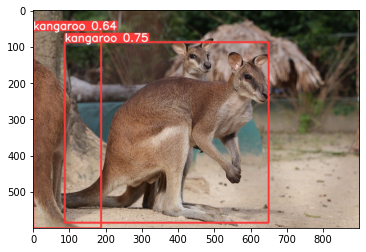

In [ ]:
image = Image.open('/content/yolov5/runs/detect/exp/00010.jpg')
plt.imshow(image)

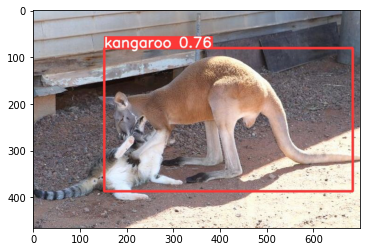

In [ ]:
image = Image.open('/content/yolov5/runs/detect/exp2/00100.jpg')
plt.imshow(image)

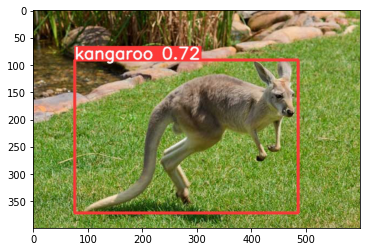

In [ ]:
image = Image.open('/content/yolov5/runs/detect/exp3/00109.jpg')
plt.imshow(image)

### Try on a Youtube video

In [ ]:
# Interrupt runtime after 1 min if the video is too long
#!python detect.py --source 'https://www.youtube.com/watch?v=wqctLW0Hb_0'
!python detect.py --source 'https://youtu.be/KBsqQez-O4w'

detect: weights=yolov5s.pt, source=https://youtu.be/KBsqQez-O4w, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-161-ge54e758 torch 1.10.0+cu111 CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.5 GFLOPs
cv2.imshow() is disabled in Google Colab environments
1/1: https://youtu.be/KBsqQez-O4w...  Success (4509 frames 1280x720 at 29.97 FPS)

0: 384x640 6 cars, 1 truck, Done. (0.310s)
0: 384x640 6 cars, 1 truck, 1 suitcase, Done. (0.295s)
0: 384x640 8 cars, 1 truck, Done. (0.272s)
0: 384x640 9 cars, Done. (0.310s)
0: 384x640 9 cars, 1 truck, Done. (0.247s)
0: 384x640 10 cars, Done. (0.256s)
0: 384x640 10 cars, 2

In [ ]:
# Convert mp4 to webm
!ffmpeg -i /content/yolov5/runs/detect/exp8/KBsqQez-O4w.mp4 -vcodec vp9 ./DetectionResult.webm

ffmpeg version 3.4.8-0ubuntu0.2 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)
  configuration: --prefix=/usr --extra-version=0ubuntu0.2 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --enable-gpl --disable-stripping --enable-avresample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librubberband --enable-librsvg --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvorbis --enable-libvpx --enable-libwavpack --enable-libwebp --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lib

In [ ]:
# Check the Result!!
import io
from base64 import b64encode
from IPython.display import HTML

with  io.open('/content/yolov5/DetectionResult.webm','r+b') as f:
    mp4 = f.read()
data_url = "data:video/webm;base64," + b64encode(mp4).decode()
HTML("""
<video width=800 controls>
      <source src="%s" type="video/webm">
</video>
""" % data_url)

# Step 7: Display performance analysis

Training results are automatically logged to Tensorboard and CSV as `results.csv`, which is plotted as `results.png` (below) after training completes. You can also plot any `results.csv` file manually:

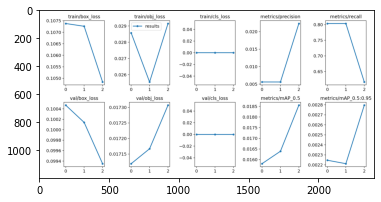

In [ ]:
image = Image.open('/content/yolov5/runs/train/exp/results.png') # Change 'exp' to the last in the train directory
plt.imshow(image)

In [ ]:
#[OPTIONAL] Alternate way of ploting the curves from CSV file
from utils.plots import plot_results 
# Change the path to the last exp under train folder.
plot_results('/content/yolov5/runs/train/exp/results.csv')  # plot 'results.csv' as 'results.png'